# Electricity comparisons

We look at the prediction from appliance surveys and compare to the observed differences.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from drs_sentani import get_survey
import seaborn as sns
import pandas as pd
survey = pd.read_excel('../data-survey/sentani-merged-cleaned-2015-06-10.xlsx')
#survey = get_survey()
import pysentani as sti
survey['access_type'] = sti.access_type(survey)

# Predicted electricity

There are no outliers in the appliance hours data in these villages so we aren't filtering.

TODO:
- document every assumption in the analysis
- check for outliers skewing data
- verify that averaging methods are consistent and that we are treating nulls correctly
- how many valid responses in each village for appliance hours?
- have any households answered some but not all of the hours questions?
- should we be creating averages based on appliance, household, or village?
- are these predictions per household?

In [3]:
# we may want to do this more fine-grained so we know what we are omitting
# we also don't want to skew results with non-responses

# is this consistent with our other methods?
survey = survey.fillna(0)

# we need to revisit the non-response hours questions.  if the appliance is owned but there are no hours reported,
# we would not count these as zero usage

# There are similar analysis on 2016-03-11

# since we want village-wide averages, filling with zeros is correct
# if we want average among appliance-owners, we omit nulls from averages

# lighting assumes five 10 watt bulbs
powers = {'TV':0.040, 
          'fridge':0.100, 
          'radio':0.010, 
          'fan':0.050, 
          'rice_cooker':0.350, 
          'lighting':0.050}
appliance_list = ['TV', 'fridge', 'radio', 'fan', 'rice_cooker', 'lighting']

for appliance in appliance_list:
    # create column label from appliance names
    wk_col = 'app_{}_per_wk'.format(appliance)
    hr_col = 'app_{}_hrs'.format(appliance)
    energy_col = 'daily_{}_energy'.format(appliance)
    weekly_hr_col = 'weekly_{}_hrs'.format(appliance)
    
    # if null or within range use value, otherwise use max possible value
    survey[hr_col] = survey[hr_col].where(survey[hr_col].isnull() | (survey[hr_col] <= 24), 24)
    survey[wk_col] = survey[wk_col].where(survey[wk_col].isnull() | (survey[wk_col] <= 7), 7)

    # ensure non-null values are within bounds
    assert(all(survey[wk_col].dropna() <= 7))
    assert(all(survey[wk_col].dropna() >= 0))
    assert(all(survey[hr_col].dropna() <= 24))
    assert(all(survey[hr_col].dropna() >= 0))

    survey[weekly_hr_col] = survey[wk_col] * survey[hr_col]    
    survey[energy_col] = survey[weekly_hr_col] / 7 * powers[appliance]

survey['total_daily_energy'] = (survey['daily_TV_energy'] + survey['daily_fridge_energy'] +
                                survey['daily_radio_energy'] + survey['daily_fan_energy'] +
                                survey['daily_rice_cooker_energy'] + survey['daily_lighting_energy'])

survey.rename(columns={'total_daily_energy': 'daily_energy_mean'},inplace = True)
subsurvey = survey[['daily_energy_mean','access_type','village_name']]

# the index name is giving me fits here
sort = subsurvey.groupby(['village_name']).mean()
sort['village_name'] = sort.index

sort['access_type'] = sti.access_type(sort)
village_names = ['Ajau', 'Asei', 'Atamali', 'Ayapo', 'Kensio']
# is there a cleaner way here?
predicted = sort[[v in village_names for v in sort['village_name']]]

# Measured electricity

In [4]:
import pandas as pd

def parse_file(energy_file_name):
    # read in raw CSV file for preprocessing
    energy_file = open(energy_file_name)
    # append data lines after header beginning with 'Timestamp'
    # dump lines from communications messages or empty lines and write to string
    file_string = ''
    omit_strings = ['Power Up', 'Communication Lost', 'Power Down', ',,,,,,,,,,,']
    # append data not matching omit_strings after sentinel is reached
    data_found = False
    for line in energy_file.readlines():
        if 'Timestamp' in line:
            data_found = True
        if not any(omit in line for omit in omit_strings) and data_found:
            file_string += line
    return file_string    

def create_data_frame(energy_file_name):
    # use pre-parsed string to read in data file to pandas and sort by date
    file_string = parse_file(energy_file_name)
    import io
    energy_data = pd.read_csv(io.StringIO(file_string),
                          index_col=0, 
                          parse_dates=[0], 
                          thousands=',')
    energy_data = energy_data.sort_index()
    return energy_data

def get_energy_stats(energy_data):
    energy = energy_data['kWh export']
    resampled = energy.resample('D').diff()
    return resampled.mean(), resampled.median()

# Data on the number of connections is from AE Report #5, dated 26 June 2015. 
energy_file_names = (('Ajau', 121, "../data-meter/Data_Logs Ajau Agustus.csv"),
                     ('Atamali', 40, "../data-meter/Data_Logs Atamali Agustus.csv"),
                     ('Ayapo', 103, "../data-meter/Data_Logs Ayapo Agustus.csv"),
                     ('Asei', 33, "../data-meter/Data_Logs ASEI July.csv"),
                     ('Kensio', 20, "../data-meter/Data_Logs Kensio Agustus.csv"))

output = {}
verbose = False
for village, connections, energy_file_name in energy_file_names: 
    energy_data = create_data_frame(energy_file_name)
    mean, median = get_energy_stats(energy_data)
    if verbose: print(village, mean, median)
    output[village] = {'mean kWh per day': mean,
                       'mean kWh per day per household': mean/connections,
                       'median kWh per day': median}

output_data = pd.DataFrame(output).T
measured = output_data
measured['village_name'] = measured.index

/Users/dsoto/anaconda/envs/sotolab/lib/python3.4/site-packages/ipykernel/__main__.py:32: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)


# Create comparison table

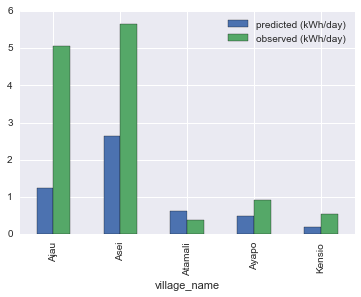

In [8]:
comparison = predicted.merge(measured)
comparison = comparison[['village_name', 'daily_energy_mean', 'mean kWh per day per household']]

comparison.index = comparison['village_name']
comparison.rename(columns={'daily_energy_mean':'predicted (kWh/day)',
                           'mean kWh per day per household':'observed (kWh/day)'},
                  inplace=True)
comparison.plot(kind='bar')
plt.savefig('electricity-comparisons.png')

In [6]:
comparison

,village_name,predicted (kWh/day),observed (kWh/day)
village_name,,,
Ajau,Ajau,1.249592,5.050263
Asei,Asei,2.637685,5.662375
Atamali,Atamali,0.626163,0.384255
Ayapo,Ayapo,0.495869,0.926089
Kensio,Kensio,0.201654,0.539094
